In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def load_data(impressions_file_path, click_file_path, conversion_file_path):
    # Assigning Column Names to the data from ReadMe
    column_names = [
    "BidID", "Timestamp", "Logtype", "VisitorID", "User-Agent", "IP", "Region", "City",
    "Adexchange", "Domain", "URL", "AnonymousURLID", "AdslotID", "Adslotwidth",
    "Adslotheight", "Adslotvisibility", "Adslotformat", "Adslotfloorprice",
    "CreativeID", "Biddingprice", "Payingprice", "KeypageURL", "AdvertiserID", "User_tag"
    ]

    # Assigning Creative ID to a numerical Value
    createive_id_mapping = {'e1af08818a6cd6bbba118bb54a651961': 0, '44966cc8da1ed40c95d59e863c8c75f0': 1, '832b91d59d0cb5731431653204a76c0e': 2, '59f065a795a663140e36eec106464524': 3, '48f2e9ba15708c0146bda5e1dd653caa': 4, 'a499988a822facd86dd0e8e4ffef8532': 5, '4ad7e35171a3d8de73bb862791575f2e': 6, 'b90c12ed2bd7950c6027bf9c6937c48a': 7, '47905feeb59223468fb898b3c9ac024d': 8, '00fccc64a1ee2809348509b7ac2a97a5': 9, 'fe222c13e927077ad3ea087a92c0935c': 10, 'f65c8bdb41e9015970bac52baa813239': 11, '8dff45ed862a740986dbe688aafee7e5': 12, '4b724cd63dfb905ebcd54e64572c646d': 13, 'e049ebe262e20bed5f9b975208db375b': 14, 'cb7c76e7784031272e37af8e7e9b062c': 15, '612599432d200b093719dd1f372f7a30': 16, '23485fcd23122d755d38f8c89d46ca56': 17, '0cd33fcb336655841d3e1441b915748d': 18, '011c1a3d4d3f089a54f9b70a4c0a6eb3': 19, '13606a7c541dcd9ca1948875a760bb31': 20, 'd881a6c788e76c2c27ed1ef04f119544': 21, '80a776343079ed94d424f4607b35fd39': 22, 'd5cecca9a6cbd7a0a48110f1306b26d1': 23, '77819d3e0b3467fe5c7b16d68ad923a1': 24, '2f88fc9cf0141b5bbaf251cab07f4ce7': 25, '86c2543527c86a893d4d4f68810a0416': 26, '3d8f1161832704a1a34e1ccdda11a81e': 27, 'd01411218cc79bc49d2a4078c4093b76': 28, '2abc9eaf57d17a96195af3f63c45dc72': 29, '6b9331e0f0dbbfef42c308333681f0a3': 30, '7eb0065067225fa5f511f7ffb9895f24': 31, '23d6dade7ed21cea308205b37594003e': 32, 'c936045d792f6ea3aa22d86d93f5cf23': 33, 'fb5afa9dba1274beaf3dad86baf97e89': 34, '4400bf8dea968a0068824792fd336c4c': 35, '7097e4210dea4d69f07f0f5e4343529c': 36, '1a43f1ff53f48573803d4a3c31ebc163': 37, '82f125e356439d73902ae85e2be96777': 38, '5c4e0bb0db45e2d1b3a14f817196ebd6': 39, 'ff5123fb9333ca095034c62fdaaf51aa': 40, '62f7f9a6dca2f80cc00f17dcda730bc1': 41, 'c938195f9e404b4f38c7e71bf50263e5': 42, '3b805a00d99d5ee2493c8fb0063e30e9': 43, '87945ed58e806dbdc291b3662f581354': 44, 'e87d7633d474589c2e2e3ba4eda53f6c': 45, '6cdf8fdd3e01122b09b5b411510a2385': 46, '0055e8503dc053435b3599fe44af118b': 47, 'bc27493ad2351e2577bc8664172544f8': 48}

    # Reading Data (Reading impression data as it has User_Tag which is neccessary for training)
    imp = pd.read_csv(impressions_file_path, delimiter='\t',names=column_names ,low_memory=True)
    conv = pd.read_csv(conversion_file_path, delimiter='\t',names=column_names, low_memory=True)
    clk = pd.read_csv(click_file_path, delimiter='\t',names=column_names, low_memory=True)

    # Mapping Creative ID to a numerical Value
    imp['CreativeID'] = imp['CreativeID'].map(createive_id_mapping)

    # Reading User Profile
    with open('Adobe Devcraft PS/user.profile.tags.txt') as f:
        tag_dict = {}
        for idx, line in enumerate(f.readlines()):
            tag_dict[line[:5]] = line[6:]
    f.close()

    # One hot Encoding User Tags
    imp['User_tag'] = imp['User_tag'].str.split(',')
    imp = imp.explode('User_tag')
    imp = pd.get_dummies(imp, columns=['User_tag'])
    user_cols = [col for col in imp.columns if col.startswith('User_')]
    imp = imp.groupby('BidID', as_index=False).agg({**{col: 'max' for col in user_cols}, **{col: 'first' for col in imp.columns if col not in user_cols + ['BidID']}})

    # Adding User Tag column which is not present in all the samples
    for key in tag_dict:
        flag = 0
        for col in imp.columns:
            if col[:4] == 'User' and col[-5:] == key:
                flag = 1
                break
        if not flag:
            print(f"Key {key} not in column ")
            print(f"Attribute : {tag_dict[key]}")            
            imp[f'User_tag_{key}'] = False

    clk_label = imp['BidID'].isin(clk['BidID'])
    conv_label = imp['BidID'].isin(conv['BidID'])

    # Dropping Unneccessary Columns
    imp = imp.drop(['BidID', 'Logtype', 'VisitorID', 'User-Agent', 'IP', 
                    'Adexchange', 'Domain', 'URL', 'AnonymousURLID', 'AdslotID', 
                    'Adslotfloorprice', 'Biddingprice', 'KeypageURL', 'Timestamp'], axis=1)


    # stratify_label = clk_label 
    # imp_train, imp_val, clk_train, clk_val, conv_train, conv_val = train_test_split(
    #     imp, clk_label, conv_label, train_size=0.999999, stratify=stratify_label
    # ) 
    return imp,clk_label,conv_label

In [10]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

def apply_smote(imp_train_df, label_df):
    """
    Applies SMOTE to balance the dataset using a single label.
    
    Parameters:
    imp_train_df (pd.DataFrame): Feature dataframe.
    label_df (pd.DataFrame or pd.Series): Single label dataframe/series.

    Returns:
    pd.DataFrame, pd.Series: Resampled feature dataframe and label series.
    """
    # Convert DataFrames to NumPy arrays
    imp_train_np = imp_train_df.to_numpy()
    label_np = label_df.to_numpy().ravel()  # Flatten if needed

    # Apply SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    imp_train_resampled, label_resampled = smote.fit_resample(imp_train_np, label_np)

    # Convert back to pandas DataFrame
    imp_train_resampled_df = pd.DataFrame(imp_train_resampled, columns=imp_train_df.columns)
    label_resampled_df = pd.Series(label_resampled, name=label_df.name)

    print(f"New imp_train shape: {imp_train_resampled_df.shape}")
    print(f"New label shape: {label_resampled_df.shape}")

    return imp_train_resampled_df, label_resampled_df

def balance_val_set(val_features_df, val_labels_df, target_class_ratio=1.0, strategy="over"):
    """
    Resamples the validation set to balance the minority and majority classes
    according to the specified ratio.

    Parameters:
    - val_features_df (pd.DataFrame): Feature dataframe.
    - val_labels_df (pd.Series): Label series.
    - target_class_ratio (float): The desired ratio of minority class to majority class.
      - Example: 1.0 means equal classes, 0.5 means minority will be half of the majority.
    - strategy (str): "over" for oversampling the minority, "under" for undersampling the majority.

    Returns:
    - pd.DataFrame, pd.Series: Resampled feature dataframe and label series.
    """
    # Count the number of samples per class
    class_counts = val_labels_df.value_counts()
    if len(class_counts) < 2:
        raise ValueError("Dataset must contain at least two classes.")

    # Identify minority and majority classes
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()

    # Determine target samples per class
    majority_count = class_counts[majority_class]
    minority_count = class_counts[minority_class]

    if strategy == "over":
        target_minority = int(majority_count * target_class_ratio)  # Increase minority class
        target_majority = majority_count  # Keep majority as it is
    elif strategy == "under":
        target_majority = int(minority_count / target_class_ratio)  # Reduce majority class
        target_minority = minority_count  # Keep minority as it is
    else:
        raise ValueError("Invalid strategy! Use 'over' or 'under'.")

    # Separate data by class
    minority_df = val_features_df[val_labels_df == minority_class]
    majority_df = val_features_df[val_labels_df == majority_class]

    minority_labels = val_labels_df[val_labels_df == minority_class]
    majority_labels = val_labels_df[val_labels_df == majority_class]

    # Apply resampling
    if strategy == "over":
        sampler = RandomOverSampler(sampling_strategy={minority_class: target_minority}, random_state=42)
    else:  # "under"
        sampler = RandomUnderSampler(sampling_strategy={majority_class: target_majority}, random_state=42)

    features_resampled, labels_resampled = sampler.fit_resample(pd.concat([minority_df, majority_df]),
                                                                pd.concat([minority_labels, majority_labels]))

    # Convert back to DataFrame
    features_resampled_df = pd.DataFrame(features_resampled, columns=val_features_df.columns)
    labels_resampled_df = pd.Series(labels_resampled, name=val_labels_df.name)

    print(f"New validation set size: {features_resampled_df.shape[0]}")
    print(f"Class distribution after resampling:\n{labels_resampled_df.value_counts()}")

    return features_resampled_df, labels_resampled_df



In [15]:
imp_train , clk_train , conv_train = load_data(impressions_file_path="Adobe_dataset/imp.06.txt",
                                               click_file_path="Adobe_dataset/clk.06.txt",
                                               conversion_file_path="Adobe_dataset/conv.06.txt")

imp_val , clk_val , conv_val = load_data(impressions_file_path="Adobe_dataset/imp.07.txt",
                                               click_file_path="Adobe_dataset/clk.07.txt",
                                               conversion_file_path="Adobe_dataset/conv.07.txt")

Key 16751 not in column 
Attribute : Long-term interest/sex

Key 16751 not in column 
Attribute : Long-term interest/sex



In [16]:
imp_train, clk_train = apply_smote(imp_train, clk_train)
imp_val_balance, clk_val_balance = balance_val_set(imp_val, clk_val, strategy='over')

New imp_train shape: (3627852, 53)
New label shape: (3627852,)
New validation set size: 3598134
Class distribution after resampling:
BidID
True     1799067
False    1799067
Name: count, dtype: int64


Accuracy: 0.5603512820812121


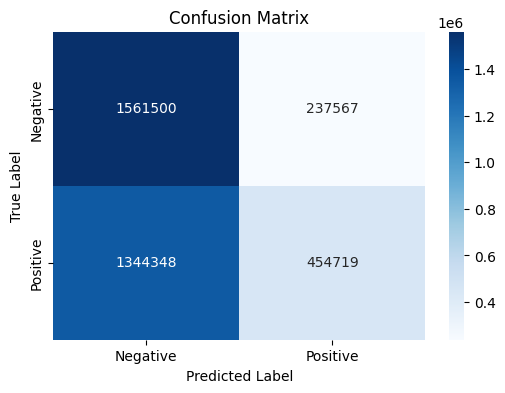

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score


# Initialize and train the Decision Tree model
clk_model = DecisionTreeClassifier(criterion="gini", max_depth=13, random_state=42)
clk_model.fit(imp_train, clk_train)

# Get predicted probabilities instead of class labels
clk_probs = clk_model.predict_proba(imp_val_balance)[:, 1]  # Probability for class 1

# Apply custom threshold of 0.1
clk_pred = (clk_probs >= 0.1).astype(int)

# Evaluate the model
accuracy = accuracy_score(clk_val_balance, clk_pred)
print(f"Accuracy: {accuracy}")
# Generate confusion matrix
cm = confusion_matrix(clk_val_balance, clk_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Optional: Visualize the tree
# from sklearn.tree import plot_tree
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# plot_tree(clk_model, filled=True, feature_names=imp_train.columns, class_names=str(np.unique(clk_train)))
# plt.show()